In [1]:
import sys
sys.path.insert(0, '../stellargraph')

In [2]:
import json
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 4

In [3]:
from stellargraph import StellarGraph
from stellargraph.data import BiasedRandomWalk
from gensim.models import Word2Vec

### Чтение данных задачи

Используемый граф — взаимные ссылки страниц из Википедии на тему ["крокодилы"](https://snap.stanford.edu/data/wikipedia-article-networks.html). Целевая переменная — количество просмотров каждой страницы.

In [4]:
df_edges = pd.read_csv('data/musae_crocodile_edges.csv')
df_target = pd.read_csv('data/musae_crocodile_target.csv')

### Построим граф

In [5]:
g = nx.from_pandas_edgelist(df_edges, 'id1', 'id2', create_using=nx.Graph())

### Выведем количество вершин и рёбер графа и график целевой переменной

Number of nodes: 11631
Number of edges: 170918


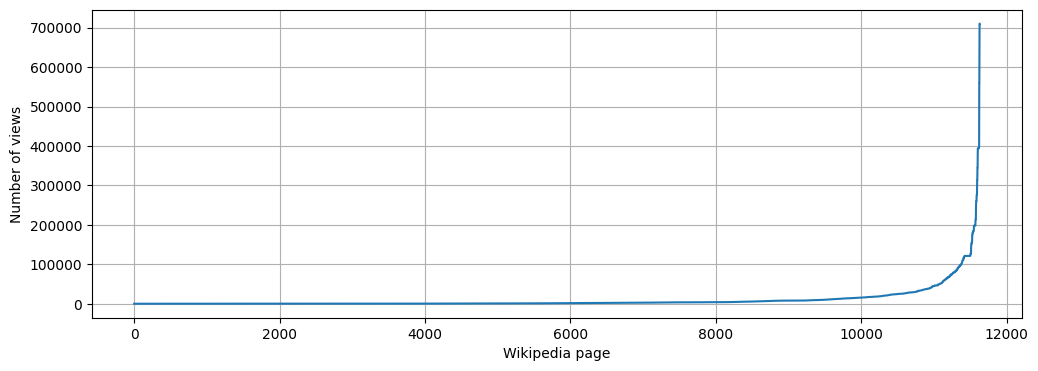

In [6]:
print('Number of nodes: {}'.format(g.number_of_nodes()))
print('Number of edges: {}'.format(g.number_of_edges()))
plt.plot(sorted(df_target['target']))
plt.grid(True)
plt.xlabel('Wikipedia page')
plt.ylabel('Number of views')
plt.show()

### Немного теории по используемому способу получения признаков
([Источник](https://medium.com/nlplanet/two-minutes-nlp-using-word2vec-to-learn-node-embeddings-on-graphs-ebece432a4b6))

Какие есть способы генерации признаков вершин графа? В первом занятии мы изучили такие важные признаки, как
1) degree centrality

2) betweenness centrality

3) closeness centrality

(Более полный список можно найти в [статье на Википедии](https://ru.wikipedia.org/wiki/%D0%A6%D0%B5%D0%BD%D1%82%D1%80%D0%B0%D0%BB%D1%8C%D0%BD%D0%BE%D1%81%D1%82%D1%8C))

Эти признаки являются важными, но сообщают не очень много о топологии графа, т.е. о том, как его вершины связаны между собой. Для этой задачи кажется естественным взять матрицу смежности графа, которая как раз и описывает эту топологию, но тогда возникает проблема с количеством признаков - оно будет равно числу вершин и в случае достаточно больших графов будет чрезмерным, что подходит не для всех классических алгоритмов машинного обучения. В принципе, такие алгоритмы достаточно хорошо работают на компактном, небольшом количестве признаков и было бы здорово научиться описывать топологию графа именно таким образом.

Здесь могут пригодится алгоритмы [word2vec](https://ru.wikipedia.org/wiki/Word2vec), которые умеют генерировать векторные представления для корпусов текстов. Не слишком вдаваясь в детали их работы, опишем основные принципы:

1) модель word2vec получает на вход некоторый набор текстов

2) элементарной единицей текста может являться символ, часть слова или слово целиком (aka токен)

3) модель создаёт словарь корпуса и в процессе обучения на входном наборе текстов подбирает векторные представления этого словаря.

Полученные векторные представления основаны на контекстной близости единиц текста (токенов) и достаточно хорошо описывают набор текстов, на основании которого они были получены.

### Признаки графов на основе Word2Vec

Такую же идею можно применить для графов. Действительно, пусть элементарными единицами "текста" будут строковые представления вершин графа, а корпусом текста - [случайные блуждания](https://ru.wikipedia.org/wiki/%D0%A1%D0%BB%D1%83%D1%87%D0%B0%D0%B9%D0%BD%D0%BE%D0%B5_%D0%B1%D0%BB%D1%83%D0%B6%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5#%D0%9D%D0%B0_%D0%B3%D1%80%D0%B0%D1%84%D0%B0%D1%85) в этом графе.

**Пример графа:**
<!-- ![Граф](https://miro.medium.com/v2/resize:fit:4800/format:webp/1*Ow9BkdG4tlYzMBfo5pm4qQ.png) -->
<div>
<img src="https://miro.medium.com/v2/resize:fit:4800/format:webp/1*Ow9BkdG4tlYzMBfo5pm4qQ.png" width="500"/>
</div>

**Полный корпус "текстов", случайный путь и вершина как элементарная единица текста**
<!-- ![Блуждания](https://miro.medium.com/v2/resize:fit:4800/format:webp/1*2ly12E4ugckar1HTGknlmA.png) -->
<div>
<img src="https://miro.medium.com/v2/resize:fit:4800/format:webp/1*2ly12E4ugckar1HTGknlmA.png" width="500"/>
</div>

Тогда можно сгенерировать достаточно большое количество случайных путей, перевести их в строковый вид и передать в одну из реализаций модели word2vec по своему выбору для получения признаков вершин!

### Сгенерируем признаки

In [7]:
# Параметры генерации
# - длина генерируемого случайного пути
# - количество путей, генерируемых для каждой вершины графа
# - вероятность возврата в начальную вершину в процессе генерации
# - количество генерируемых признаков
# - количество процессов, используемых при создании модели Word2Vec
len_walk = 20
num_runs = 5
p_ret = 0.4
emb_size = 50
num_workers = 4

In [8]:
%%time
# 1) Переводим граф в формат StellarGraph
# 2) Создаём объект для генерации путей в графе
# 3) Генерируем пути
# 4) Переводим пути в строковый формат
# 5) Создаём модель Word2Vec, которая будет уметь генерировать признаки вершин из путей графа
g_st = StellarGraph.from_networkx(g)
rw = BiasedRandomWalk(g_st)
walks = rw.run(nodes=list(g_st.nodes()), length=len_walk, n=num_runs, p=p_ret)
str_walks = [list(map(str, w)) for w in walks]
model = Word2Vec(str_walks, vector_size=emb_size, workers=num_workers)

CPU times: user 1min 5s, sys: 485 ms, total: 1min 5s
Wall time: 1min 4s


In [11]:
print(len(walks))
for w in walks[:5]:
    print(w)

58155
[9622, 9091, 4245, 4912, 5364, 2950, 3433, 1362, 180, 9091, 7291, 9091, 9398, 2794, 8370, 10274, 1503, 10274, 1503, 8579]
[9622, 9091, 1514, 9091, 10954, 6364, 4449, 4170, 2946, 4722, 3232, 4722, 3232, 4722, 4170, 8481, 10860, 1095, 6364, 1773]
[9622, 9091, 4136, 9091, 4136, 5961, 9398, 4691, 10076, 3709, 8545, 8869, 8545, 1664, 6224, 8545, 3272, 8545, 3549, 11256]
[9622, 9091, 5702, 356, 7965, 3665, 5508, 4709, 5508, 9813, 8334, 7274, 3169, 11453, 1179, 8633, 7733, 5154, 3609, 6240]
[9622, 9091, 6769, 3865, 5547, 9121, 10572, 8723, 6827, 10511, 8914, 8019, 11216, 417, 8802, 8165, 8802, 8352, 11216, 7316]


### Сгенерируем датасеты

In [12]:
# Датасет #1: 
# X - признаки, полученные с помощью алгоритма word2vec
# Y - количество просмотров страницы (вершины графа)
nodes = g_st.nodes()
fts = np.array([model.wv[str(node)] for node in nodes])
df_fts = pd.DataFrame(np.column_stack([nodes, fts]))
columns = ['node_id'] + ['X_{}'.format(i) for i in range(fts.shape[1])]
df_fts.columns = columns
df1 = df_fts.merge(df_target, left_on='node_id', right_on='id')
df1 = df1.drop(['node_id', 'id'], axis=1)
df1 = df1.rename(columns={'target': 'Y'})
print(df1.shape)
print(df1.columns)

(11631, 51)
Index(['X_0', 'X_1', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6', 'X_7', 'X_8', 'X_9',
       'X_10', 'X_11', 'X_12', 'X_13', 'X_14', 'X_15', 'X_16', 'X_17', 'X_18',
       'X_19', 'X_20', 'X_21', 'X_22', 'X_23', 'X_24', 'X_25', 'X_26', 'X_27',
       'X_28', 'X_29', 'X_30', 'X_31', 'X_32', 'X_33', 'X_34', 'X_35', 'X_36',
       'X_37', 'X_38', 'X_39', 'X_40', 'X_41', 'X_42', 'X_43', 'X_44', 'X_45',
       'X_46', 'X_47', 'X_48', 'X_49', 'Y'],
      dtype='object')


In [13]:
%%time
# Датасет #2: добавим к предыдущему датасету два признака центральности
dc = nx.degree_centrality(g)
bc = nx.betweenness_centrality(g, k=50)  # используем k вершин, иначе будут использоваться все вершины (=долго)
# cc = nx.closeness_centrality(g)  # считается очень долго, лучше применять для небольших графов
df2 = pd.DataFrame({'node': dc.keys(), 'dc': dc.values()})
df2 = df2.merge(pd.DataFrame({'node': bc.keys(), 'bc': bc.values()}), on='node')
df2 = df2.merge(df_fts, left_on='node', right_on='node_id')
df2 = df2.merge(df_target, left_on='node', right_on='id')
df2 = df2.drop(['node_id', 'id', 'node'],axis=1)
df2 = df2.rename(columns={'target': 'Y'})
print(df2.shape)
print(df2.columns)

(11631, 53)
Index(['dc', 'bc', 'X_0', 'X_1', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6', 'X_7',
       'X_8', 'X_9', 'X_10', 'X_11', 'X_12', 'X_13', 'X_14', 'X_15', 'X_16',
       'X_17', 'X_18', 'X_19', 'X_20', 'X_21', 'X_22', 'X_23', 'X_24', 'X_25',
       'X_26', 'X_27', 'X_28', 'X_29', 'X_30', 'X_31', 'X_32', 'X_33', 'X_34',
       'X_35', 'X_36', 'X_37', 'X_38', 'X_39', 'X_40', 'X_41', 'X_42', 'X_43',
       'X_44', 'X_45', 'X_46', 'X_47', 'X_48', 'X_49', 'Y'],
      dtype='object')
CPU times: user 4.18 s, sys: 164 ms, total: 4.34 s
Wall time: 4.59 s


### Заключение

1) Выяснили, какие признаки полезно генерировать для понимания топологии графа

2) Изучили, как здесь может пригодиться Word2Vec

3) Получили два датасета для задачи регрессии (предсказание количества просмотров страниц в Википедии).

### Самостоятельная работа

1) Собрать два таких же датасета для предсказания наличия рёбер между вершинами того же графа (аналогично материалам предыдущего урока)

2) Выбрать несколько моделей для решения представленных задач: а) предсказание количества просмотров страниц (регрессия) и б) предсказание наличия рёбер между вершинами (бинарная классификация)

3) Провести эксперименты с разными моделями и датасетами.